# VAE (MNIST)

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_probability as tfp

In [2]:
!nvidia-smi -L
print(f'TensorFlow version: {tf.__version__}')

GPU 0: GeForce RTX 2080 Ti (UUID: GPU-3cb47403-efa9-71ae-1700-c27de6cb0d0a)
TensorFlow version: 2.3.1


In [3]:
(X_train, _), _ = tf.keras.datasets.mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], -1) / 255.0
X_train = (X_train > 0.5).astype('float32')
D = X_train.shape[-1]
EPOCHS = 30

train_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

Epoch 1/30
938/938 [==============================] - 9s 9ms/step - loss: 10770.1006
Epoch 2/30
938/938 [==============================] - 8s 9ms/step - loss: 8960.2891
Epoch 3/30
938/938 [==============================] - 9s 9ms/step - loss: 8504.4482
Epoch 4/30
938/938 [==============================] - 8s 9ms/step - loss: 8266.2490
Epoch 5/30
938/938 [==============================] - 8s 9ms/step - loss: 8128.7363
Epoch 6/30
938/938 [==============================] - 8s 9ms/step - loss: 8032.1763
Epoch 7/30
938/938 [==============================] - 9s 10ms/step - loss: 7960.2534
Epoch 8/30
938/938 [==============================] - 9s 9ms/step - loss: 7907.7075
Epoch 9/30
938/938 [==============================] - 9s 9ms/step - loss: 7861.9814
Epoch 10/30
938/938 [==============================] - 9s 9ms/step - loss: 7833.5483
Epoch 11/30
938/938 [==============================] - 9s 10ms/step - loss: 7812.5308
Epoch 12/30
938/938 [==============================] - 9s 10ms/step - l

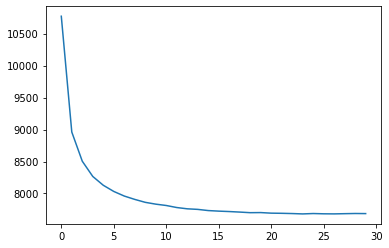

In [4]:
class Encoder(tf.keras.layers.Layer):

    def __init__(self, latent_dim, hidden_dim):
        super().__init__()
        self._hidden = tf.keras.layers.Dense(hidden_dim, activation='relu')
        self._mean = tf.keras.layers.Dense(latent_dim, activation='relu')
        self._std = tf.keras.layers.Dense(latent_dim, activation='relu')

    def call(self, inputs):
        x = self._hidden(inputs)
        z_mean = self._mean(x)
        z_std = tf.math.softplus(self._std(x)) + 1e-6
        epsilon = tf.random.normal(tf.shape(z_mean))
        z = epsilon * z_std + z_mean
        return z_mean, z_std, z


class Decoder(tf.keras.layers.Layer):

    def __init__(self, output_dim, hidden_dim):
        super().__init__()
        self._hidden = tf.keras.layers.Dense(hidden_dim, activation='relu')
        self._output = tf.keras.layers.Dense(output_dim)

    def call(self, inputs):
        x = self._hidden(inputs)
        logits = self._output(x)
        dist = tfp.distributions.Bernoulli(logits=logits)
        return dist, dist.sample()


class VariationalAutoencoder(tf.keras.Model):

    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        self._encoder = Encoder(latent_dim=latent_dim, hidden_dim=hidden_dim)
        self._decoder = Decoder(output_dim=input_dim, hidden_dim=hidden_dim)

    def call(self, inputs):
        z_mean, z_std, z = self._encoder(inputs)
        dist, reconstructed = self._decoder(z)
        
        kl_loss = -tf.math.log(z_std) + 0.5 * (z_std ** 2 + z_mean ** 2) - 0.5
        kl_loss = tf.math.reduce_sum(kl_loss, axis=1)
        expected_log_likelihood = tf.math.reduce_sum(dist.log_prob(inputs), axis=1)
        negative_elbo = -tf.math.reduce_sum(expected_log_likelihood - kl_loss)
        self.add_loss(negative_elbo)
        
        return reconstructed


model = VariationalAutoencoder(input_dim=D, hidden_dim=200, latent_dim=100)
optimizer = tf.keras.optimizers.RMSprop(0.001)

losses = []
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    step_losses = []
    progbar = tf.keras.utils.Progbar(len(train_dataset), interval=0.5)

    for step, batch in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            reconstructed = model(batch)
            loss = sum(model.losses)

        grads = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
        
        step_losses.append(loss)
        progbar.add(1, values=[('loss', loss)])

    losses.append(np.mean(step_losses))

plt.plot(np.arange(EPOCHS), losses)
plt.show()

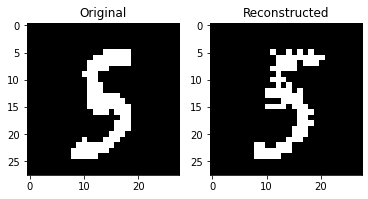

In [5]:
sample = X_train[np.random.randint(len(X_train))]
original_image = sample.reshape(28, 28)
reconstructed_image = model(sample.reshape(1, -1)).numpy().reshape(28, 28)

plt.subplot(1, 2, 1)
plt.imshow(original_image, cmap='gray')
plt.title('Original')
plt.subplot(1, 2, 2)
plt.imshow(reconstructed_image, cmap='gray')
plt.title('Reconstructed')
plt.show()